<a href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/sentiment_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 George Mihaila.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GPUs in Natural Language Processing



<td>
    <a target="_blank" href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/sentiment_clustering.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
  <a target="_blank" href="https://github.com/gmihaila/gtc2020_instructor_training.git"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Datasets used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.

* [The Signal Media One-Million News Articles Dataset](https://research.signal-ai.com/newsir16/signal-dataset.html): This dataset is released by Signal Media to facilitate conducting research on news articles. The dataset contains **265,512 Blog articles** and **734,488 News articles** the average length of an article is 405 words. 
 
 **NOTE:** *To obtain the dataset, please follow this link:* **http://goo.gl/forms/5i4KldoWIX**


### Content:

 * Use Sentence Embeddings from pretrained state of the art language models, in this case **bert-base-nli-stsb-mean-tokens**, to transform text data data into fixed vector feratures of length **768 features**.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.


## Environment Sanity Check

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4 or P100.

https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD

In [0]:
## VERSION CHECK [FACTORY RESET UNTIL GET AT LEAST 16280MiB GPU ]
!nvidia-smi
!nvcc -V
!python -V; pip -V

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Python 3.6.9
pip 19.3.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)


## Installs

**Set up script installs for Rapids**

1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
1. removes incompatible files
1. Install RAPIDS libraries
1. Set necessary environment variables
1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
1. Recommend select v0.10
If running v0.11 or higher, updates pyarrow library to 0.15.x.

In [0]:
!pip install git+https://github.com/arvkevi/kneed
!pip install git+https://github.com/UKPLab/sentence-transformers
!pip install -U ipykernel

# Install RAPIDS
!rm rapids-colab.sh
!wget -nc https://raw.githubusercontent.com/rapidsai/notebooks-contrib/890b04ed8687da6e3a100c81f449ff6f7b559956/utils/rapids-colab.sh
!bash rapids-colab.sh

import sys, os

dist_package_index = sys.path.index("/usr/local/lib/python3.6/dist-packages")
sys.path = sys.path[:dist_package_index] + ["/usr/local/lib/python3.6/site-packages"] + sys.path[dist_package_index:]
sys.path
if os.path.exists('update_pyarrow.py'): ## This file only exists if you're using RAPIDS version 0.11 or higher
  exec(open("update_pyarrow.py").read(), globals())

!pip install -U ipykernel

  Cloning https://github.com/arvkevi/kneed to /tmp/pip-req-build-lc8qzrkq
  Running command git clone -q https://github.com/arvkevi/kneed /tmp/pip-req-build-lc8qzrkq
     |████████████████████████████████| 13.1 MB 4.7 MB/s 
     |████████████████████████████████| 7.0 MB 51.0 MB/s 
     |████████████████████████████████| 26.1 MB 1.2 MB/s 
     |████████████████████████████████| 90 kB 12.9 MB/s 
     |████████████████████████████████| 67 kB 7.4 MB/s 
     |████████████████████████████████| 294 kB 102.0 MB/s 
  Created wheel for kneed: filename=kneed-0.5.1-py2.py3-none-any.whl size=10036 sha256=a40f90018d8a3af7708f716e3666b80ca7f273ca65806f81d7b973ca67cc0836
  Stored in directory: /tmp/pip-ephem-wheel-cache-n5pg90s5/wheels/34/1e/5b/8fccab4811880902601d6770c8af716cde606d78a033ac84fb
Successfully built kneed


  Cloning https://github.com/UKPLab/sentence-transformers to /tmp/pip-req-build-vw30ouet
  Running command git clone -q https://github.com/UKPLab/sentence-transformers /tmp/pip-req-build-vw30ouet
  Using cached transformers-2.3.0-py3-none-any.whl (447 kB)
     |████████████████████████████████| 59 kB 3.1 MB/s 
     |████████████████████████████████| 753.4 MB 21 kB/s 
     |████████████████████████████████| 1.5 MB 66.2 MB/s 
Processing /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422/sacremoses-0.0.38-cp36-none-any.whl
  Using cached sentencepiece-0.1.85-cp36-cp36m-manylinux1_x86_64.whl (1.0 MB)
     |████████████████████████████████| 128 kB 85.8 MB/s 
     |████████████████████████████████| 689 kB 77.5 MB/s 
     |████████████████████████████████| 81 kB 12.6 MB/s 
     |████████████████████████████████| 5.9 MB 70.0 MB/s 
     |████████████████████████████████| 69 kB 8.6 MB/s 
     |████████████████████████████████| 547 kB 76.9 MB/s 
  Created wheel fo

## Downloads

In [0]:
!wget https://github.com/gmihaila/gtc2020_instructor_training/raw/master/imdb_reviews_all_labeled.csv

--2020-02-11 20:44:07--  https://github.com/gmihaila/gtc2020_instructor_training/raw/master/imdb_reviews_all_labeled.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gmihaila/gtc2020_instructor_training/master/imdb_reviews_all_labeled.csv [following]
--2020-02-11 20:44:07--  https://raw.githubusercontent.com/gmihaila/gtc2020_instructor_training/master/imdb_reviews_all_labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65862311 (63M) [text/plain]
Saving to: ‘imdb_reviews_all_labeled.csv’

imdb_reviews_all_la 100%[===================>]  62.81M   282MB/s    in 0.2s    

2020-02-11 20:44:08 (

# Imports

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from multiprocessing import Process, Pipe
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from kneed import KneeLocator
import seaborn as sns
import pandas as pd
from multiprocessing import Process, Pipe
from sentence_transformers import SentenceTransformer
import cudf
from cuml import NearestNeighbors, KMeans, TSNE, TruncatedSVD, UMAP
from cuml import PCA as cuPCA
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
import json
import gzip


pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

os.environ['NUMBAPRO_NVVM']='/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so'  
os.environ['NUMBAPRO_LIBDEVICE']='/usr/local/cuda-10.0/nvvm/libdevice'

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

PRETRAINED_MODEL = 'bert-base-nli-stsb-mean-tokens'

# Functions

In [0]:
def context_embedding(text, name_of_model, batch_size=1000, use_device="cuda"):

  embed_model = SentenceTransformer(model_name_or_path=name_of_model,
                                    device=torch.device(use_device))

  encodings_text = embed_model.encode(sentences=text, 
                                          batch_size=batch_size, 
                                          show_progress_bar=True)
  # empty GPU cache
  torch.cuda.empty_cache()
  return  np.array(encodings_text)


def best_kmeans_elbow(features, n_clusters, verbose=False, show=False):
  features = cudf.DataFrame.from_gpu_matrix(features)
  # features = np.array(features)
  
  clusters = list(range(2, n_clusters))
  distortions = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(features)
    
    distortion = kmean_model.inertia_
    distortions.append(distortion)

    if verbose: print("For n_clusters =", n_clusters, "Distortion is :", distortion)

  kn = KneeLocator(clusters, distortions, curve='convex', direction='decreasing')
  best_k = int(kn.knee)

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      distortions,
                      color="coral", 
                      label="Distortions")
  plot.set(xlabel='k', ylabel='Distortions')
  plot.set_title('Using Elbow method for best k')
  plot.axvline(x=best_k)
  if show: plt.show()
  fig = plot.get_figure()
  fig.savefig("elbow_distortions.png")
  return



def best_kmeans_silhouette(features, n_clusters):
  features = np.array(features)
  
  clusters = list(range(2, n_clusters))
  silhouettes = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(np.array(features))

    cluster_labels = kmean_model.predict(features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouettes.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

  best_k = clusters[silhouettes.index(max(silhouettes))]

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      silhouettes,
                      color="coral", 
                      label="Silhouette Average Score")
  plot.set(xlabel='k', ylabel='Silhouette Average Score')
  plot.set_title('Silhouette Average Score for each cluster k')
  plot.axvline(x=best_k)
  fig = plot.get_figure()
  fig.savefig("silhouette_avg.png")
  return


def kmeans(k, features):
  features = cudf.DataFrame.from_gpu_matrix(features)
  kmean_model = KMeans(n_clusters=k)
  kmean_model.fit(features)
  labels = kmean_model.labels_
  return labels, kmean_model



def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot'):
  # move to GPU matrix
  features = cudf.DataFrame.from_gpu_matrix(features)
  pca_cuml = cuPCA(n_components=n_components,
                   random_state=random_state)
  # pca_cuml.fit(features)
  # reduced_features = pca_cuml.transform(gdf_float)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features.values[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features.values[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    plt.show()
    cluster_plot.savefig("pca_plot.png")
  return reduced_features.values


def predictions_overlap(model_predicitons, true_predicitons):
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = [" ".join([str(cluster)+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

def custom_sample(text, model, prediction_id_label):
  text_embedding = context_embedding(text=[text], 
                                      name_of_model=PRETRAINED_MODEL, 
                                      batch_size=1, use_device="cuda")
  prediction_label = model.predict(np.array(text_embedding))
  return prediction_id_label[prediction_label[0]]

def read_news_data(filename, verbose=False):
  news_contents = []
  with gzip.open(filename, "rb") as f:
    for index, line in enumerate(f, start=1):
      entry = json.loads(line.decode())      
      news_contents.append(entry['content'])
      if (index%50000==0) and verbose:
        print(index)
  return news_contents

# Dataset

In [0]:
movies_sentiments_df = pd.read_csv('imdb_reviews_all_labeled.csv')

movies_reviews = movies_sentiments_df['reviews'].values
sentiments_reviews = movies_sentiments_df['sentiments'].values

print(movies_reviews[:2])
print(sentiments_reviews[:2])
print(len(sentiments_reviews))

["This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was

# Embeddings

In [0]:
movies_reviews_embeddings = context_embedding(text=movies_reviews, name_of_model=PRETRAINED_MODEL, batch_size=100, use_device="cuda")

Batches: 100%|██████████| 500/500 [06:44<00:00,  2.17s/it]


# Best k-means

In [0]:
max_n_cluster = 10

## Elbow Method

For n_clusters = 2 Distortion is : 4172841.5
For n_clusters = 3 Distortion is : 4053103.75
For n_clusters = 4 Distortion is : 3978637.5
For n_clusters = 5 Distortion is : 3931936.0
For n_clusters = 6 Distortion is : 3888730.5
For n_clusters = 7 Distortion is : 3859651.0
For n_clusters = 8 Distortion is : 3831168.25
For n_clusters = 9 Distortion is : 3805342.5


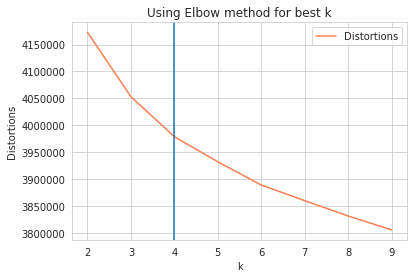

In [0]:
best_kmeans_elbow(features=movies_reviews_embeddings, n_clusters=max_n_cluster, verbose=True)

## Silhouette Method [time consuming]

For n_clusters = 2 The average silhouette_score is : 0.03998012
For n_clusters = 3 The average silhouette_score is : 0.03486097
For n_clusters = 4 The average silhouette_score is : 0.03242191
For n_clusters = 5 The average silhouette_score is : 0.03142608
For n_clusters = 6 The average silhouette_score is : 0.020849094
For n_clusters = 7 The average silhouette_score is : 0.01837415
For n_clusters = 8 The average silhouette_score is : 0.017937498
For n_clusters = 9 The average silhouette_score is : 0.016972205


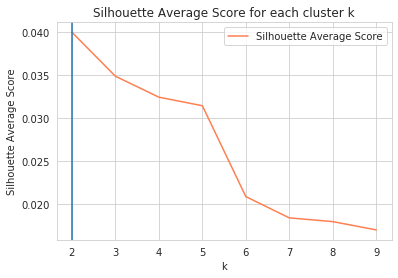

In [0]:
best_kmeans_silhouette(features=movies_reviews_embeddings, n_clusters=max_n_cluster)

## Best K model

In [0]:
best_k = 2

best_kmeans_labels, _ = kmeans(k=best_k, features=np.array(movies_reviews_embeddings))

## PCA Visualize

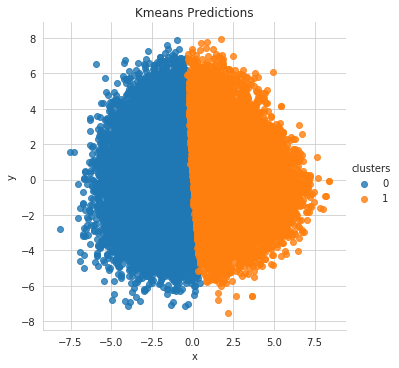

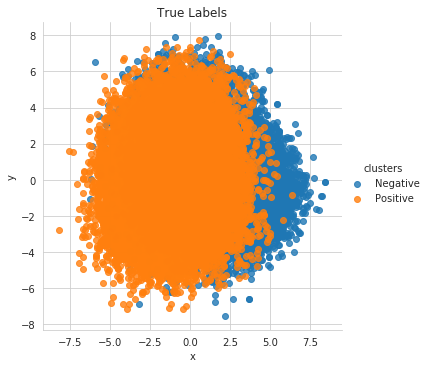



Found labels: [0, 1]



,labels,cluster_match
0,0,1:19310 0:6693
1,1,0:18307 1:5690


In [0]:
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=sentiments_reviews)
matching_df.head()

# K Means Sentiments

## k=3 sentiments

In [0]:
k_sentiments = 3

### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

### Find Labels

In [0]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews)
matching_df.head()

Found labels: [0, 1, 2]



,labels,cluster_match
0,0,1:14202 0:3847
1,1,0:14621 1:3302
2,2,1:7496 0:6532


### Visualize

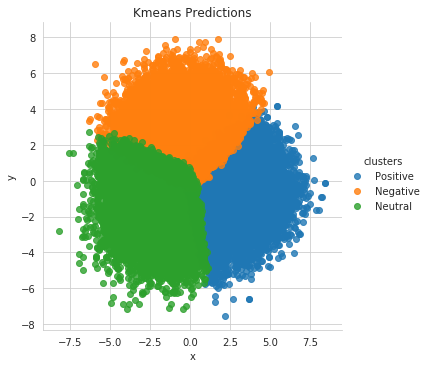

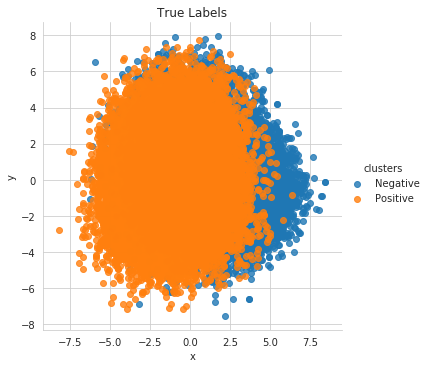

In [0]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [0]:
show_samples(target_predicitons_class=0, 
              texts=movies_reviews,
             trues=sentiments_reviews, 
             trues_id_sentiment=ID_SENTIMENT,
              predicitons=kmeans_labels,
             predictions_id_sentiment=kmeans_id_sentiment,
              n_samples=3)

Text  ... Prediction Sentiment
0  The idea of bringing Dracula to contemporary times isn't bad--after all, it might revive the series a bit by injecting a new story element into a series that Hammer has all but exhausted in a long series of generally excellent movies. However, because the present day turned out to be the crappy early 1970s, the results were pretty silly and looked more like LOVE AT FIRST BITE (a deliberate comedy). Seeing Christopher Lee in a film filled with 70s hip lingo and electric guitar chords and laughable rock music just seemed beyond stupid. To make matters worse, the acting is much more over-the-top here--with an intense and silly performance by "Johnny Alucard". I also thought it was really funny that it took Van Helsing's grandson to notice that "Alucard" is "Dracula" spelled backwards--no one else figured this out for themselves! Wow, what cunning!! <br /><br />So because so much of the movie was bad, why did it still earn an almost respectable score of 4? Well, when the story came to the expected showdown between Van Helsing (Peter Cushing) and Drac (Christopher Lee), it was exciting and ended very well. Additionally, and I know this will sound very sexist, but if I had to watch a bad film, at least Stephanie Beacham's character wore some really nice outfits that revealed her ample...."talents", so to speak. So at least it was a pretty film to watch.<br /><br />By the way, the film ends with the phrase "may he rest in FINAL peace" at the end, though this was not the final Hammer Dracula film with Lee. He returned for "The Satanic Rites of Dracula" just a short time later and it was in many ways even worse than this dud of a monster film.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## k=4 sentiments

In [0]:
k_sentiments = 4

### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

In [0]:
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


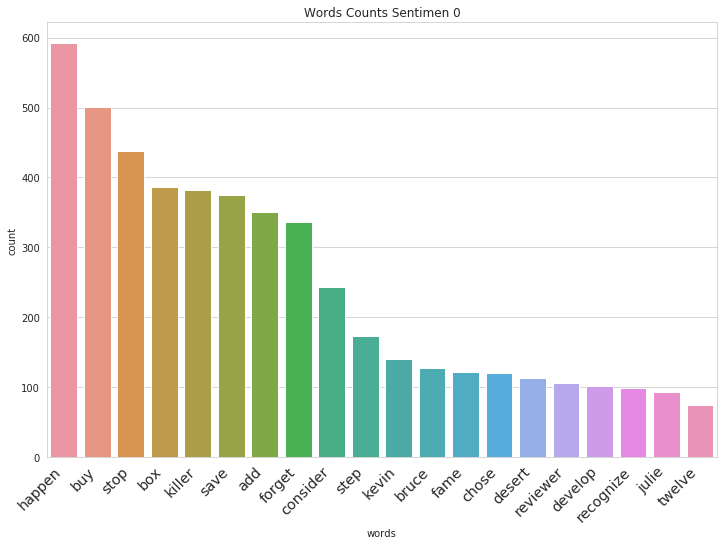

In [0]:
def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  assert pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    top_words = nltk.pos_tag(tokens=top_words)
    top_words = [val[0] for val in top_words if val[1]==pos_tag]
    # top_words = [word for word in top_words if nltk.pos_tag(tokens=[word])[0][1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
    break

clusters_words_plot(texts=movies_reviews, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag='VB',
                    top_clip=10,
                    low_clip=30,
                    stop_words=stopwords.words('english'), 
                    magnify=2)

### Find Labels

In [0]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews)
matching_df.head()

Found labels: [0, 1, 2, 3]



,labels,cluster_match
0,0,1:6137 0:4365
1,1,0:12583 1:2268
2,2,1:10914 0:2875
3,3,1:5681 0:5177


### Visualize

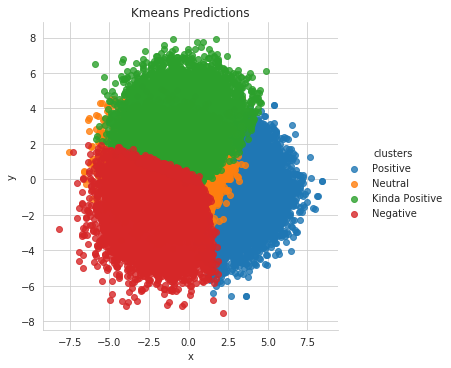

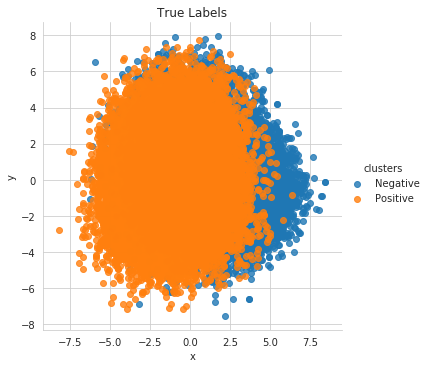

In [0]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [0]:
print(kmeans_id_sentiment)
show_samples(target_predicitons_class=3, 
              texts=movies_reviews,
             trues=sentiments_reviews, 
             trues_id_sentiment=ID_SENTIMENT,
              predicitons=kmeans_labels,
             predictions_id_sentiment=kmeans_id_sentiment,
              n_samples=3)

{0: 'Neutral', 1: 'Positive', 2: 'Negative', 3: 'Kinda Positive'}


Text  ... Prediction Sentiment
0  Recently was traveling in Norway from Bergen, Norway and stopped in the small town of Voss, Norway and there was a monument in honor of Knute Rockne who was born in Voss years ago. The people all know about Knute to this day and tour guides are proud to stop at his monument. This film is a great history of this great man and his great love for Notre Dame Never realized that Knute has such great talents in chemistry and laboratory science and also taught chemistry for years and at the same time coached the football team. Ronald Reagan played the role of George Gipp, (The Gipper) who was an outstanding football player; Reagan had a short role, but gave a great supporting role in this film. Donald Crisp, (Father John Callahan) was outstanding as a priest who always had great faith in Knute during his entire life at Notre Dame. This is a great Classic film and will be viewed by many generations to come. Enjoy.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [0]:
custom_sample(text="hi I am meh!", 
              model=kmean_model,
              prediction_id_label=kmeans_id_sentiment)

Batches: 100%|██████████| 1/1 [00:00<00:00, 57.37it/s]


'Neutral'